In [1]:
import numpy as np
import os
import wfdb
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

gait_dataset_path = 'E:/database/gait-in-neurodegenerative-disease-database-1.0.0'
gait_filenames = [
    f'{gait_dataset_path}\\{name}'
    for name in sorted(set(el.split('.')[0] for el in os.listdir(gait_dataset_path) if el.endswith('.hea')))
]
gait_data, gait_labels = [], []
for filename in gait_filenames:
    ar, meta = wfdb.rdsamp(filename)
    gait_data.append(ar)
    label = filename.split('\\')[-1]
    for i in range(len(label)):
        if label[i].isnumeric():
            label = label[:i]
            break
    gait_labels.append(label)
gait_data = np.stack(gait_data)[:, 20*300:]
gait_labels = label_encoder.fit_transform(gait_labels)

In [2]:
import numpy as np
from scipy.spatial import distance_matrix
from tqdm import tqdm

def get_weights(pts, exp=1):
    n_pts = len(pts)
    A = np.exp(-distance_matrix(pts, pts))
    b = np.ones(n_pts)
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w.reshape(-1, 1)

def signals_to_curves(signals, dim=5, stride=2):
    # last dimension = channels
    if isinstance(signals, np.ndarray):
        size = signals.shape[-2]
        result = np.concatenate([signals[..., i*stride:size-(dim-i-1)*stride, :] for i in range(dim)], axis=-1)
        return result
    elif isinstance(signals, list):
        return [signals_to_curves(signal, dim, stride) for signal in signals]
    else:
        raise ValueError

def weights_from_pclouds(pclouds, exp=0):
    if exp == 0:
        return [np.ones((pcloud.shape[0], 1)) / pcloud.shape[0] 
                for pcloud in tqdm(pclouds, total=len(pclouds), desc='weight computation', miniters=100)]
    else:
        return [get_weights(pcloud, exp) 
                for pcloud in tqdm(pclouds, total=len(pclouds), desc='weight computation', miniters=100)]

In [28]:
rng = np.random.default_rng(42)
# test_mask = np.full_like(gait_labels, False, dtype='bool')
# for i in range(4):
#     for idx in rng.choice(np.where(gait_labels == i)[0], np.sum(gait_labels == i) // 5):
#         test_mask[idx] = True

sig_len = 84000
seg_len = 500
gait_data_cut = gait_data.reshape(-1, seg_len, 2)
gait_labels_cut = np.tile(gait_labels.reshape(-1, 1), (1, sig_len//seg_len)).ravel()
# test_mask_cut = np.tile(test_mask.reshape(-1, 1), (1, sig_len//seg_len)).ravel()
test_mask = np.zeros((gait_data.shape[0], sig_len//seg_len), dtype=np.int32)
test_mask[:, int(0.8*test_mask.shape[1]):] = 1
test_mask_cut = test_mask.ravel().astype(bool)

mask_notna = ~np.isnan(gait_data_cut).any(axis=(1,2))
gait_data_cut, gait_labels_cut = gait_data_cut[mask_notna], gait_labels_cut[mask_notna]
test_mask_cut = test_mask_cut[mask_notna]

In [4]:
pclouds = signals_to_curves(gait_data_cut, 3, 20)
weights = weights_from_pclouds(pclouds, 1.)
weights_unif = weights_from_pclouds(pclouds, 0)
# embedded = embedding_pclouds(pclouds, weights)
# embedded_unif = embedding_pclouds(pclouds, weights_unif)

weight computation: 100%|██████████| 10583/10583 [00:00<00:00, 216556.91it/s]


In [18]:
import tensorflow as tf
from tensorflow import keras

class MyLayer(keras.layers.Layer):
    def __init__(self, dim, n_filters=20):
        super(MyLayer, self).__init__()
        self.wave_num = self.add_weight(
            name='wave_num',
            shape=(dim, n_filters),
            dtype=tf.float32,
            initializer=keras.initializers.HeUniform(),
            trainable=True,
        )
        # self.forward = keras.Sequential([
        #     keras.layers.Dense(
        #         units=64,
        #         activation='elu'
        #     ),
        #     keras.layers.BatchNormalization(),
        #     keras.layers.Dense(
        #         units=64,
        #         activation='elu'
        #     ),
        #     keras.layers.BatchNormalization(),
        #     keras.layers.Dense(
        #         units=64,
        #         activation='elu'
        #     ),
        #     keras.layers.BatchNormalization(),
        #     keras.layers.Dense(
        #         units=n_filters
        #     ),
        # ])
        
    def call(self, inputs, *args, **kwargs):
        pclouds, weights = inputs
        filtered = tf.math.sin(pclouds @ (2*self.wave_num-1))
        # filtered = self.forward(pclouds)
        features = tf.math.reduce_sum(filtered * weights, axis=1)
        return features
    
# X1 = tf.ragged.constant(pclouds, ragged_rank=1, inner_shape=(6, ))
# X2 = tf.ragged.constant(weights, ragged_rank=1, inner_shape=(1, ))
# X_train = [tf.ragged.boolean_mask(X1, ~test_mask_cut), tf.ragged.boolean_mask(X2, ~test_mask_cut)]
# X_test = [tf.ragged.boolean_mask(X1, test_mask_cut), tf.ragged.boolean_mask(X2, test_mask_cut)]
X_train = [np.stack(pclouds)[~test_mask_cut], np.stack(weights)[~test_mask_cut]]
X_test = [np.stack(pclouds)[test_mask_cut], np.stack(weights)[test_mask_cut]]
y_train, y_test = gait_labels_cut[~test_mask_cut], gait_labels_cut[test_mask_cut]

In [14]:
from sklearn.decomposition import PCA

my_layer = MyLayer(dim=6, n_filters=32)
tmp = my_layer(X_train).numpy()

pca = PCA()
pca.fit(tmp)
np.cumsum(pca.explained_variance_ratio_) * 100

array([ 33.286114,  49.36351 ,  57.645226,  63.557755,  68.21114 ,
        72.47276 ,  75.8488  ,  78.57534 ,  81.00571 ,  83.23638 ,
        85.33476 ,  87.33576 ,  88.83502 ,  90.30497 ,  91.50241 ,
        92.58941 ,  93.660126,  94.56468 ,  95.348366,  96.098   ,
        96.68085 ,  97.20768 ,  97.70342 ,  98.172   ,  98.53855 ,
        98.852234,  99.13495 ,  99.38432 ,  99.56353 ,  99.73172 ,
        99.87075 , 100.      ], dtype=float32)

In [29]:
from lightgbm import LGBMClassifier
F_train = my_layer(X_train).numpy()
F_test = my_layer(X_test).numpy()
model = LGBMClassifier()
model.fit(F_train, y_train)
print( np.mean( model.predict(F_train) == y_train ) )
print( np.mean( model.predict(F_test) == y_test ) )

1.0
0.9721698113207548


In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)

inputs_p = keras.Input(shape=(460, 6))
inputs_w = keras.Input(shape=(460, 1))
inputs = [inputs_p, inputs_w]
my_layer = MyLayer(dim=6, n_filters=16)
features = my_layer(inputs)
outputs = features
outputs = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=4,
        activation='softmax'
    ),
])(outputs)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(5e-2),
    metrics=['accuracy']
)
model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=1 << 6,
    validation_split=0.2
)
model.evaluate(X_test, y_test)

Epoch 1/10
106/106 [==============================] - 2s 8ms/step - loss: 0.4938 - accuracy: 0.8043 - val_loss: 9.1442 - val_accuracy: 0.0502
Epoch 2/10
106/106 [==============================] - 1s 6ms/step - loss: 0.2400 - accuracy: 0.9142 - val_loss: 9.8912 - val_accuracy: 0.0372
Epoch 3/10
106/106 [==============================] - 1s 6ms/step - loss: 0.2167 - accuracy: 0.9284 - val_loss: 2.6973 - val_accuracy: 0.3839
Epoch 4/10
106/106 [==============================] - 1s 6ms/step - loss: 0.2398 - accuracy: 0.9186 - val_loss: 10.4025 - val_accuracy: 0.0543
Epoch 5/10
106/106 [==============================] - 1s 6ms/step - loss: 0.2201 - accuracy: 0.9261 - val_loss: 8.2750 - val_accuracy: 0.0685
Epoch 6/10
106/106 [==============================] - 1s 6ms/step - loss: 0.1406 - accuracy: 0.9548 - val_loss: 7.9617 - val_accuracy: 0.1353
Epoch 7/10
106/106 [==============================] - 1s 5ms/step - loss: 0.1701 - accuracy: 0.9490 - val_loss: 7.4531 - val_accuracy: 0.1359
Epoch

[1.349420189857483, 0.7811321020126343]

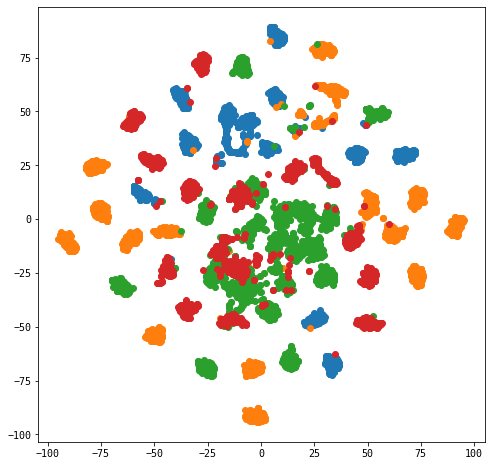

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

tsne = TSNE(n_components=2)
F_tsne = tsne.fit_transform(F_train)
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(*F_tsne[y_train==i].T)
plt.show(); plt.close();

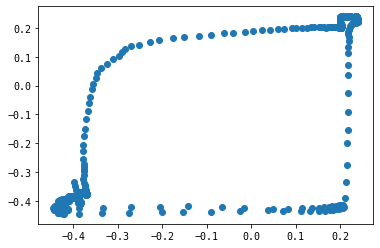

In [174]:
idx = 1000
plt.scatter(gait_data_cut[idx, 20:, 0], gait_data_cut[idx, :-20, 0])

In [42]:
rng = np.random.default_rng(42)

sig_len = 84000
seg_len = 500
gait_data_varcut = []
gait_labels_varcut = []
test_mask_varcut = []
for i in range(gait_data.shape[0]):
    base = 0
    while base < gait_data.shape[1] - 400:
        piece_size = rng.integers(400, 800+1)
        piece = gait_data[i, base:base+piece_size]
        if not np.isnan(piece).any():
            gait_data_varcut.append( piece )
            gait_labels_varcut.append( gait_labels[i] )
            test_mask_varcut.append( base > 0.8 * gait_data.shape[1] )
        base += piece_size
gait_labels_varcut = np.array(gait_labels_varcut)
test_mask_varcut = np.array(test_mask_varcut)

In [46]:
pclouds_var = signals_to_curves(gait_data_varcut, 3, 20)
weights_var = weights_from_pclouds(pclouds_var, 1.)
weights_unif = weights_from_pclouds(pclouds_var, 0)

In [ ]:
def make_uniform(pcs, ws):
    pcs, ws = pcs[:], ws[:]
    max_len = max([len(pc) for pc in pcs])
    for i, pc in enumerate(pcs):
        q, r = divmod(max_len, len(pc))
        pcs[i] = np.concatenate([pc for _ in range(q)] + [pc[:r]], axis=0)
        ws[i] = np.concatenate([w for _ in range(q)] + [w[:r]], axis=0)
    return pcs, ws